In [112]:
import numpy as np
import matplotlib.pyplot as plt
from axessettings import AxesSetting
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import linregress

## active LPF

In [113]:
# H = lambda s: A0*w0**2/(s**+alpha*w0*s+w0**2)
#Z1=Z4=R
#Z2=1/2sC  Z5=1/sC
#Z3=oo
#Rf=0  Rr=oo 
R=1000
C=1e-7
def H(f): 
    s = 2j*np.pi*f
    ret = (1/R/R)/((1/R+2*s*C)*(1/R+s*C)+s*C/R-2*s*C/R)
    return ret
H_gain_theory = lambda f: 20*np.log10(np.abs(H(f)))
H_phase_theory = lambda f: np.angle(H(f), deg=True)

3dB cutoff frequency: 1.09 kHz
time constant: 0.146 ms
slope: -36.995, intercept: 111.556, r^2: 0.997


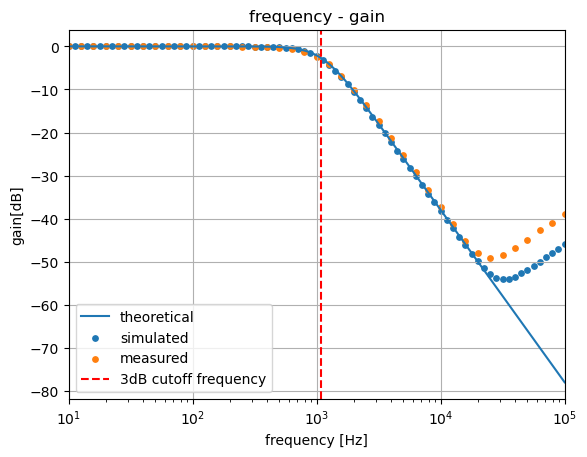

In [114]:
gain_lpf = pd.read_csv("5_bode_activelpf.csv")
lpf_spice = pd.read_csv("active_lpf.csv")
lpf_spice["gain"]=np.sqrt(lpf_spice["re"]**2+lpf_spice["im"]**2)
gain_lpf["gain_dB"] = 20*np.log10(gain_lpf["gain"])
interp_func = interp1d(gain_lpf["gain_dB"], gain_lpf["freq"], bounds_error=False, fill_value="extrapolate")

freq_3dB = interp_func(-3)
print(f"3dB cutoff frequency: {freq_3dB/1000:.2f} kHz")
T = 1/(2*np.pi*freq_3dB)
print(f"time constant: {T*1e3:.3f} ms")
dat_above_cutoff = gain_lpf[gain_lpf["freq"] > freq_3dB]
dat_cutoff = dat_above_cutoff[dat_above_cutoff["freq"] < 1e4]

log_freq = np.log10(dat_cutoff["freq"])

slope, intercept, r_value, p_value, std_err = linregress(log_freq, dat_cutoff["gain_dB"])
print(f"slope: {slope:.3f}, intercept: {intercept:.3f}, r^2: {r_value**2:.3f}")
fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True, xlabel="frequency [Hz]", ylabel="gain[dB]", grid="both", xlim=(10,1e5),xscale="log", title="frequency - gain")
axstg.plot_func(ax, H_gain_theory, label="theoretical")
ax.scatter(lpf_spice["freq"], 20*np.log10(lpf_spice["gain"]), label="simulated", s=15)
ax.scatter(gain_lpf["freq"], 20*np.log10(gain_lpf["gain"]), label="measured", s=15)
ax.axvline(freq_3dB, color="red", linestyle="--", label="3dB cutoff frequency")
axstg.apply_axes(ax)

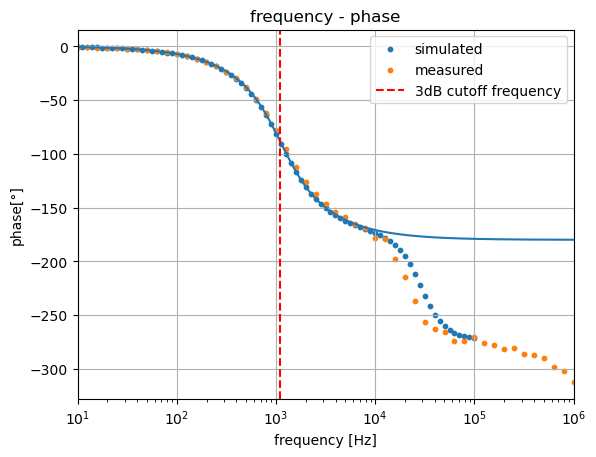

In [115]:
lpf_spice["phase"] = np.angle(lpf_spice["re"]+1j*lpf_spice["im"], deg=True)
lpf_spice["phase"] = np.where(lpf_spice["phase"] > 0, lpf_spice["phase"] - 360, lpf_spice["phase"])
fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True, xlabel="frequency [Hz]", ylabel="phase[°]", grid="both", xlim=(10,1e6),xscale="log", title="frequency - phase")
axstg.plot_func(ax, H_phase_theory)
ax.scatter(lpf_spice["freq"], lpf_spice["phase"], label="simulated",s=10)
ax.scatter(gain_lpf["freq"], gain_lpf["phase"], label="measured",s=10)
ax.axvline(freq_3dB, color="red", linestyle="--", label="3dB cutoff frequency")
axstg.apply_axes(ax)

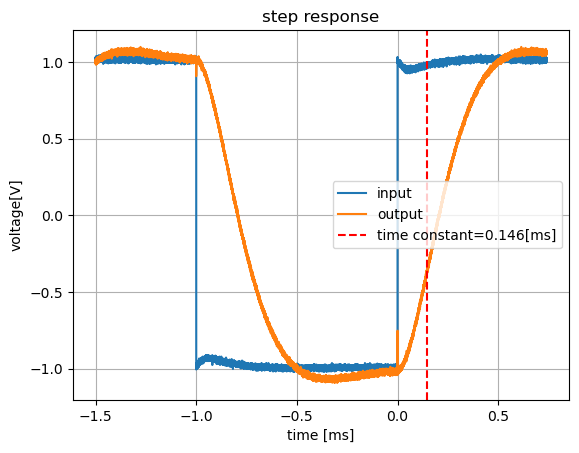

In [116]:
dat = pd.read_csv("5_osc_activelpf.csv")
fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True,xlabel="time [ms]", ylabel="voltage[V]", grid="both",title="step response")
ax.plot(dat["time"]*1000, dat["CH1"], label="input")
ax.plot(dat["time"]*1000, dat["CH2"], label="output")
ax.axvline(x=T*1000, color="red", linestyle="--", label="time constant=0.146[ms]")
# ax.plot(dat["time"], dat["CH3"], label="output")

axstg.apply_axes(ax)

## active HPF

In [132]:
#H = lambda s: ((1+Rf/Rr)/Z1/Z4)/((1/Z1+1/Z2+1/Z3)(1/Z4+1/Z5)+1/Z4/Z5-(1+Rf/Rr)/Z2/Z4)
#Z1=Z4=1/sC
#Z2=R  Z5=2R
#Z3=oo
#Rf=0  Rr=oo
R=1000
C=1e-7
def H(f): 
    s = 2j*np.pi*f
    ret = ((s*C)**2)/((s*C+1/R)*(s*C+1/(2*R))+s*C/(2*R)-s*C/R)
    return ret
H_gain_theory = lambda f: 20*np.log10(np.abs(H(f)))
H_phase_theory = lambda f: np.angle(H(f), deg=True)-360

3dB cutoff frequency: 1.40 kHz
time constant: 0.114 ms
slope: 37.686, intercept: -118.287, r^2: 0.997


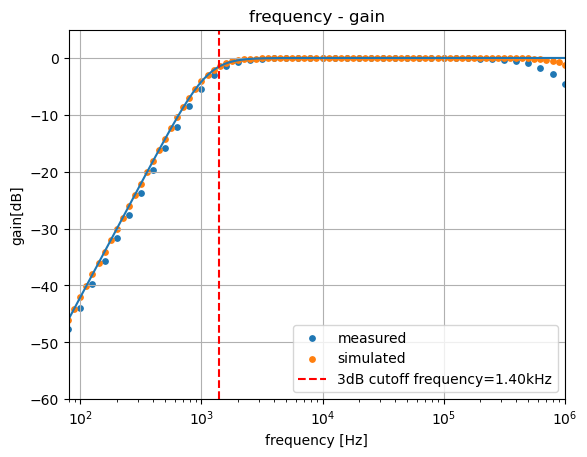

In [137]:
gain_hpf = pd.read_csv("5_bode_activehpf.csv")
hpf_spice = pd.read_csv("active_hpf.csv")
gain_hpf["gain_dB"] = 20*np.log10(gain_hpf["gain"])
hpf_spice["gain"]=np.sqrt(hpf_spice["re"]**2+hpf_spice["im"]**2)
interp_func = interp1d(gain_hpf["gain_dB"], gain_hpf["freq"], bounds_error=False, fill_value="extrapolate")

freq_3dB = interp_func(-3)
print(f"3dB cutoff frequency: {freq_3dB/1000:.2f} kHz")
T = 1/(2*np.pi*freq_3dB)
print(f"time constant: {T*1e3:.3f} ms")
dat_above_cutoff = gain_hpf[gain_hpf["freq"] < freq_3dB]
dat_cutoff = dat_above_cutoff[dat_above_cutoff["freq"] > 100]

log_freq = np.log10(dat_cutoff["freq"])

slope, intercept, r_value, p_value, std_err = linregress(log_freq, dat_cutoff["gain_dB"])
print(f"slope: {slope:.3f}, intercept: {intercept:.3f}, r^2: {r_value**2:.3f}")

fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True, xlabel="frequency [Hz]", ylabel="gain[dB]", grid="both", xlim=(80,1e6),ylim=(-60,5),xscale="log", title="frequency - gain")
axstg.plot_func(ax, H_gain_theory)
ax.scatter(gain_hpf["freq"], 20*np.log10(gain_hpf["gain"]), label="measured",s=15)
ax.scatter(hpf_spice["freq"], 20*np.log10(hpf_spice["gain"]), label="simulated", s=15)

ax.axvline(freq_3dB, color="red", linestyle="--", label=f"3dB cutoff frequency={freq_3dB/1000:.2f}kHz")
axstg.apply_axes(ax)

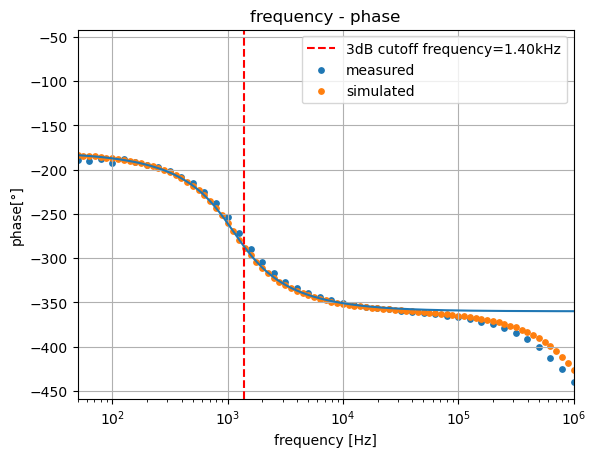

In [136]:
hpf_spice["phase"] = np.angle(hpf_spice["re"]+1j*hpf_spice["im"], deg=True)-360
fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True, xlabel="frequency [Hz]", ylabel="phase[°]", grid="both", xlim=(50,1e6),xscale="log", title="frequency - phase")
axstg.plot_func(ax, H_phase_theory)
ax.axvline(freq_3dB, color="red", linestyle="--", label=f"3dB cutoff frequency={freq_3dB/1000:.2f}kHz")
ax.scatter(gain_hpf["freq"], gain_hpf["phase"], label="measured",s=15)
ax.scatter(hpf_spice["freq"], hpf_spice["phase"], label="simulated",s=15)
axstg.apply_axes(ax)

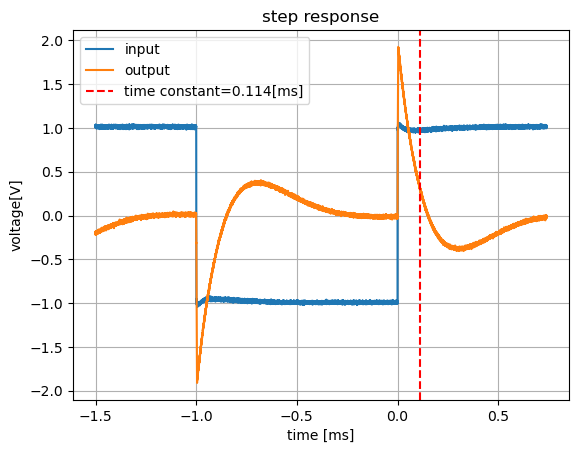

In [138]:
dat = pd.read_csv("5_osc_activehpf.csv")
fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True,xlabel="time [ms]", ylabel="voltage[V]", grid="both",title="step response")
ax.plot(dat["time"]*1000, dat["CH1"], label="input")
ax.plot(dat["time"]*1000, dat["CH2"], label="output")
ax.axvline(x=T*1000, color="red", linestyle="--", label="time constant=0.114[ms]")
# ax.plot(dat["time"], dat["CH3"], label="output")

axstg.apply_axes(ax)